<a href="https://colab.research.google.com/github/Dazzyayan/AdventOfCode24/blob/main/offline_ts2vec_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ruptures
from google.colab import drive
drive.mount('/content/drive')

# Navigate to the desired folder (replace 'mlds_research_project' with your actual folder name)
import os
os.chdir('/content/drive/MyDrive/_mlds_research_project/ts2vec/')

import sys

# Add the specific directory to the Python path
sys.path.append('/content/drive/MyDrive/_mlds_research_project/')
sys.path.append('/content/drive/MyDrive/_mlds_research_project/ts2vec/')

from ts2vec import TS2Vec
import datautils
import torch
print(torch.cuda.is_available())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
True


In [14]:
# @title Generate Simulated Data Function

# Assuming /content/drive/MyDrive/mlds_research_project is in your Python path
from sim_gen import milestone_2_sim
import numpy as np

def generate_simulated_data(n_instances=1000, train_split=0.8, M=2, pct_no_changepoints=0):
    """
    Generates simulated time series data with changepoints, performs z-score normalization,
    and splits the data into training and testing sets with corresponding ground truth changepoints.

    Args:
        n_instances (int): The total number of time series instances to generate.
        train_split (float): The proportion of data to use for training (between 0 and 1).
        M (int): Parameter for the milestone_2_sim.generate_changepoint_ar_data function.
        pct_no_changepoints (float): The percentage of instances to generate with no changepoints (M=0).
                                     Defaults to 0, meaning 0% of data will have no changepoints.

    Returns:
        tuple: A tuple containing:
            - train_data (np.ndarray): Padded training data (n_train_instances, max_len, n_features).
            - test_data (np.ndarray): Padded testing data (n_test_instances, max_len, n_features).
            - train_ground_truth_cps (list): List of ground truth changepoints for the training data.
            - test_ground_truth_cps (list): List of ground truth changepoints for the testing data.
    """
    # Initialize empty lists to store data and changepoints
    synthetic_data = []
    synthetic_cps = []
    synthetic_normalized_data = []

    # Loop to generate data
    for _ in range(n_instances):
        # Determine if this instance should have no changepoints
        generate_no_changepoints = np.random.rand() < (pct_no_changepoints / 100.0)

        if generate_no_changepoints:
            # Generate a single instance of data with no changepoints (M=0)
            data, cps, _ = milestone_2_sim.generate_changepoint_ar_data(M=0)
        else:
            # Generate a single instance of data with changepoints
            data, cps, _ = milestone_2_sim.generate_changepoint_ar_data(M=M)


        # Reshape the data if it's 1D to ensure a feature dimension
        if data.ndim == 1:
            data = data.reshape(-1, 1)

        # --- Add Z-score Normalization ---
        # Calculate mean and standard deviation, avoiding division by zero for constant data
        mean = np.mean(data, axis=0)
        std_dev = np.std(data, axis=0)
        # Apply z-score normalization: (data - mean) / std_dev
        # Handle cases where std_dev is zero (constant time series)
        normalized_data = np.zeros_like(data)
        non_zero_std_mask = std_dev != 0
        normalized_data[:, non_zero_std_mask] = (data[:, non_zero_std_mask] - mean[non_zero_std_mask]) / std_dev[non_zero_std_mask]
        # ---------------------------------

        # Append the original data (for calculating max_len) and changepoints to the lists
        synthetic_data.append(data)
        synthetic_cps.append(cps)
        # Append the normalized data
        synthetic_normalized_data.append(normalized_data)


    # Determine the maximum length among the original generated time series
    max_len = max(data.shape[0] for data in synthetic_data)

    # Split data into training and testing sets
    train_size = int(train_split * n_instances)
    train_data_list = synthetic_normalized_data[:train_size]
    test_data_list = synthetic_normalized_data[train_size:]
    train_ground_truth_cps = synthetic_cps[:train_size]
    test_ground_truth_cps = synthetic_cps[train_size:]


    # Pad the synthetic normalized data instances to the maximum length
    padded_train_data = []
    for data_instance in train_data_list:
        padding_length = max_len - data_instance.shape[0]
        padding_length = max(0, padding_length) # Ensure padding length is not negative
        padded_instance = np.pad(data_instance, ((0, padding_length), (0, 0)), mode='constant', constant_values=0)
        padded_train_data.append(padded_instance)

    padded_test_data = []
    for data_instance in test_data_list:
        padding_length = max_len - data_instance.shape[0]
        padding_length = max(0, padding_length) # Ensure padding length is not negative
        padded_instance = np.pad(data_instance, ((0, padding_length), (0, 0)), mode='constant', constant_values=0)
        padded_test_data.append(padded_instance)


    # Convert the list of padded arrays into a single NumPy array
    # Handle cases where train_split is 0 or 1, resulting in empty lists
    train_data_gen = np.stack(padded_train_data, axis=0) if padded_train_data else np.array([])
    test_data_gen = np.stack(padded_test_data, axis=0) if padded_test_data else np.array([])

    # Return the generated data and changepoints
    return train_data_gen, test_data_gen, train_ground_truth_cps, test_ground_truth_cps

# Example usage (optional - can be removed or kept for testing the function)
train_data_gen, test_data_gen, train_ground_truth_cps, test_ground_truth_cps = generate_simulated_data(n_instances=200, train_split=0.5, M=2, pct_no_changepoints=10)
# print(f"Shape of generated and padded training data (normalized): {train_data_gen.shape}")
# print(f"Shape of generated and padded testing data (normalized): {test_data_gen.shape}")
# print(f"Number of ground truth changepoint lists for training: {len(train_ground_truth_cps)}")
# print(f"Number of ground truth changepoint lists for testing: {len(test_ground_truth_cps)}")

In [3]:
# @title Eval method
def evaluate_changepoint_detection(ground_truth_cps, detected_cps, tolerance=5):
    """
    Evaluates changepoint detection performance for a single instance.

    Args:
        ground_truth_cps (list): List of ground truth changepoint timestamps.
        detected_cps (list): List of detected changepoint timestamps.
        tolerance (int): The tolerance window around ground truth changepoints
                         to consider a detected changepoint a True Positive.

    Returns:
        tuple: (tp, fp, fn, precision, recall, f1_score)
               tp (int): True Positives
               fp (int): False Positives
               fn (int): False Negatives
               precision (float): Precision score
               recall (float): Recall score
               f1_score (float): F1-score
    """
    tp = 0
    fp = 0
    fn = 0

    # Create a boolean array to track if a ground truth CP has been matched
    matched_gt = [False] * len(ground_truth_cps)

    # Count True Positives and False Positives
    for detected_cp in detected_cps:
        is_tp = False
        for i, gt_cp in enumerate(ground_truth_cps):
            if abs(detected_cp - gt_cp) <= tolerance and not matched_gt[i]:
                tp += 1
                matched_gt[i] = True
                is_tp = True
                break # Move to the next detected CP once a match is found
        if not is_tp:
            fp += 1

    # Count False Negatives (ground truth CPs that were not matched)
    fn = len(ground_truth_cps) - sum(matched_gt)

    # Calculate Precision, Recall, and F1-score
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    return tp, fp, fn, precision, recall, f1_score

In [15]:
# @title Train TS2Vec
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from ts2vec import TS2Vec
from scipy.signal import find_peaks, correlate
import torch
import torch.nn.functional as F

def train_ts2vec_model(train_data, input_dims=1, output_dims=320, device=0):
    """
    Trains a TS2Vec model on the provided training data.

    Args:
        train_data (np.ndarray): Training data (n_instances, n_timestamps, n_features).
        input_dims (int): Input dimensions for TS2Vec model.
        output_dims (int): Output dimensions for TS2Vec representations.
        device (int): Device to use for training (0 for GPU, -1 for CPU).

    Returns:
        TS2Vec: The trained TS2Vec model.
    """
    print("Training TS2Vec model...")
    model = TS2Vec(
        input_dims=input_dims,
        device=device,
        output_dims=output_dims
    )
    loss_log = model.fit(
        train_data,
        verbose=False
    )
    print("TS2Vec model training complete.")
    return model

  # Train the TS2Vec model
trained_model = train_ts2vec_model(
    train_data=train_data_gen,
    input_dims=train_data_gen.shape[-1], # Use the actual input dimensions from the data
    device=0 # Specify device if needed
)

Training TS2Vec model...
TS2Vec model training complete.


In [5]:
# @title TIRE Filters
def tire_matched_filter(signal, window_size):
    """
    Matched filter for dissimilarity measure smoothing (and zero-delay weighted moving average filter for shared feature smoothing)

    Args:
        signal: input signal
        window_size: window size used for CPD
    Returns:
        filtered signal
    """
    mask = np.ones((2*window_size+1,))
    for i in range(window_size):
        mask[i] = i/(window_size**2)
        mask[-(i+1)] = i/(window_size**2)
    mask[window_size] = window_size/(window_size**2)

    signal_out = np.zeros(np.shape(signal))

    if len(np.shape(signal)) >1:
        for i in range(np.shape(signal)[1]):
            signal_extended = np.concatenate((signal[0,i]*np.ones(window_size), signal[:,i], signal[-1,i]*np.ones(window_size)))
            signal_out[:,i] = np.convolve(signal_extended, mask, 'valid')
    else:
        signal = np.concatenate((signal[0]*np.ones(window_size), signal, signal[-1]*np.ones(window_size)))
        signal_out = np.convolve(signal, mask, 'valid')

    return signal_out

def tire_minmaxscale(data, a, b):
    """
    Scales data to the interval [a,b]
    """
    data_min = np.amin(data)
    data_max = np.amax(data)

    return (b-a)*(data-data_min)/(data_max-data_min)+a

In [6]:
# @title TS2VecChangepointDetector
# Assuming TS2Vec class is available from previous imports
# from ts2vec import TS2Vec
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from scipy.signal import find_peaks
import pandas as pd # Import pandas for robust moving average with NaNs
from typing import List, Optional, Tuple, Dict, Any
import bottleneck as bn # Import bottleneck for efficient moving average
from numpy.lib.stride_tricks import sliding_window_view # For generalized moving average


class TS2VecChangepointDetector:
    """
    A class to perform offline changepoint detection using a trained TS2Vec model.

    This class encapsulates the process of generating time series representations,
    calculating L1 distances between representations of sliding windows (masked vs unmasked),
    processing the resulting distance signal, and detecting changepoints by finding peaks.
    It supports optional filtering of encodings and different detection signals.
    Input data is scaled using tire_minmaxscale to the range [-1, 1].

    Attributes:
        model (TS2Vec): The trained TS2Vec model.
        sliding_length (int): Sliding window length for encoding TS2Vec representations.
        sliding_padding (int): Sliding window padding for encoding TS2Vec representations.
        local_window_size (int): The size of the local window used for the custom mask
                                 and for maxpooling representations.
        prominence_threshold (float): The required prominence of peaks in the detection
                                      signal to be considered changepoints (for the original peak finding method).
        moving_average_window (int): The window size for computing the moving average
                                     of the L1 distance signal. Also used
                                     as the window size for `tire_matched_filter` if
                                     `apply_filter_to_encodings` is True.
        detection_signal (str): Which signal to use for changepoint detection.
                                Must be one of 'raw' (L1 distances), 'moving_average'
                                (smoothed L1 distances), or 'difference' (absolute
                                difference between raw and smoothed L1 distances).
        apply_filter_to_encodings (bool): Whether to apply the `tire_matched_filter`
                                         to the TS2Vec encodings *before* calculating
                                         L1 distances.
        l1_distances: Optional[np.ndarray]: Stores the calculated raw L1 distances
                                            between masked and unmasked encodings.
                                            None before `detect_changepoints` is called.
        moving_avg_l1_distances: Optional[np.ndarray]: Stores the moving average of
                                                       L1 distances. None before detection.
        l1_abs_diff_from_ma: Optional[np.ndarray]: Stores the absolute difference between
                                                   l1 distances and their moving average.
                                                   None before detection.
        l2_maxpool_unmasked_distances (Optional[np.ndarray]): Stores the L2 distances between the maxpooled window representation and the unmasked representation at the end of the window.
                                                              None before `detect_changepoint` is called.
        _signal_for_detection: Optional[np.ndarray] = None # Stores the signal used for peak detection.
        detected_cps: Optional[List[int]] = None # Stores the detected changepoint timestamps.
        _data_shape: Optional[Tuple[int, ...]] = None # To store the shape of the last processed data
        _output_dims: int # To store the output dimensions of the TS2Vec model
        _l2_peak_timestamps: Optional[List[int]] = None # Stores the timestamps of peaks in the filtered L2 signal
        _filtered_l2_maxpool_unmasked_distances: Optional[np.ndarray] = None # Stores the filtered L2 maxpool vs unmasked distances


    """
    def __init__(self, model: Any, sliding_length: int = 1, sliding_padding: int = 6,
                 local_window_size: int = 6, prominence_threshold: float = 1.0,
                 moving_average_window: int = 5, detection_signal: str = 'moving_average',
                 apply_filter_to_encodings: bool = False):
        """
        Initializes the TS2VecChangepointDetector with a trained model and parameters.

        Args:
            model (Any): The trained TS2Vec model object. It should have an `encode` method and an `output_dims` attribute.
            sliding_length (int): Sliding window length for encoding. Defaults to 1.
            sliding_padding (int): Sliding window padding for encoding. Defaults to 6.
            local_window_size (int): The size of the local window for maxpooling and the custom mask. Defaults to 6.
            prominence_threshold (float): The required prominence of peaks for changepoint detection (for original peak finding). Defaults to 1.0.
            moving_average_window (int): The window size for computing the moving average. Defaults to 5.
            detection_signal (str): Which signal to use for changepoint detection ('raw', 'moving_average', 'difference'). Defaults to 'moving_average'.
                                    Must be one of the valid detection signals.
            apply_filter_to_encodings (bool): Whether to apply the tire_matched_filter to the encodings before calculating L1 distance. Defaults to False.
        """
        self.model = model
        self.sliding_length = sliding_length
        self.sliding_padding = sliding_padding
        self.local_window_size = local_window_size
        self.prominence_threshold = prominence_threshold
        self.moving_average_window = moving_average_window
        self.detection_signal = detection_signal
        self.apply_filter_to_encodings = apply_filter_to_encodings


        # Attributes to store results
        self.l1_distances: Optional[np.ndarray] = None
        self.moving_avg_l1_distances: Optional[np.ndarray] = None
        self.l1_abs_diff_from_ma: Optional[np.ndarray] = None
        self.l2_maxpool_unmasked_distances: Optional[np.ndarray] = None
        self._signal_for_detection: Optional[np.ndarray] = None
        self.detected_cps: Optional[List[int]] = None
        self._data_shape: Optional[Tuple[int, ...]] = None
        self._output_dims = 320
        self._l2_peak_timestamps: Optional[List[int]] = None
        self._filtered_l2_maxpool_unmasked_distances: Optional[np.ndarray] = None


        valid_detection_signals = ['raw', 'moving_average', 'difference']
        if self.detection_signal not in valid_detection_signals:
            print(f"Warning: Invalid detection_signal '{self.detection_signal}'. Using 'moving_average'.")
            self.detection_signal = 'moving_average'


    def _maxpool(self, poold: torch.Tensor) -> torch.Tensor:
        """
        Helper function to apply maxpooling on a tensor.
        """
        p = int(np.log2(poold.shape[1] - 1)) if poold.shape[1] > 1 else 0
        output = F.max_pool1d(poold.transpose(1, 2),
                              kernel_size = (1 << (p + 1)) + 1,
                              stride = 1,
                              padding = 1 << p
                             ).transpose(1, 2)
        return output

    def _calculate_l1_distance(self, vec1: np.ndarray, vec2: np.ndarray) -> float:
        """
        Helper function to calculate the L1 (Manhattan) distance between two vectors.
        """
        if vec1.shape != vec2.shape:
             raise ValueError("Shape mismatch in vectors for L1 distance calculation.")
        return np.sum(np.abs(vec1 - vec2))

    def _calculate_l2_distance(self, vec1: np.ndarray, vec2: np.ndarray) -> float:
        """
        Helper function to calculate the L2 (Euclidean) distance between two vectors.
        """
        if vec1.shape != vec2.shape:
             raise ValueError("Shape mismatch in vectors for L2 distance calculation.")
        return np.linalg.norm(vec1 - vec2)


    def _moving_average(self, data: np.ndarray, window_size: int) -> np.ndarray:
        """
        Helper function to compute the moving average using pandas for robust NaN handling.
        """
        if window_size <= 1:
            return data
        if window_size > len(data):
            return np.full(len(data), np.nan)

        return pd.Series(data).rolling(window=window_size, min_periods=1).mean().values







    def detect_changepoints(self, data: np.ndarray, debug_peaks: bool = False) -> List[int]:
        """
        Performs changepoint detection on the provided time series data.

        Encodes the entire time series, calculates L1 distances between masked and
        unmasked representations, processes the resulting distance signal based on
        the selected detection signal, and detects changepoints.

        Args:
            data (np.ndarray): Input time series data. Can be 1D (n_timestamps,),
                               2D (n_timestamps, n_features), or 3D (1, n_timestamps, n_features).
            debug_peaks (bool): If True, print the results and properties of find_peaks operations.

        Returns:
            List[int]: A list of detected changepoint timestamps.
        """
        # Ensure data has a batch dimension for model.encode
        if data.ndim == 2:
            data = data[np.newaxis, :, :]
        elif data.ndim == 1:
             data = data[np.newaxis, :, np.newaxis]
        elif data.ndim != 3:
            raise ValueError(f"Input data must be 1D, 2D, or 3D. Got shape {data.shape}")

        self._data_shape = data.shape # Store the shape for plotting
        n_timestamps = self._data_shape[1]

        # --- Removed Scaling ---


        # print("Generating masked and unmasked sliding window representations for the entire data...")
        # Generate representations with the custom mask for the entire time series
        masked_representations = self.model.encode(
            data, # Use original data for encoding
            causal=True,
            sliding_length=self.sliding_length,
            sliding_padding=self.sliding_padding,
            mask=f"custom_{self.local_window_size}" # Use the custom mask
        )
        masked_instance_repr = masked_representations.squeeze(0)

        # Generate representations without any mask for the entire time series
        unmasked_representations = self.model.encode(
            data, # Use original data for encoding
            causal=True,
            sliding_length=self.sliding_length,
            sliding_padding=self.sliding_padding,
            mask=None # No mask
        )
        unmasked_instance_repr = unmasked_representations.squeeze(0)

        # Ensure shapes match before proceeding
        if masked_instance_repr.shape != unmasked_instance_repr.shape:
            raise ValueError(f"Shape mismatch between masked ({masked_instance_repr.shape}) and unmasked ({unmasked_instance_repr.shape}) representations.")

        # The encoded representations are aligned with the *end* of the sliding window.
        # The valid indices for comparison are where both masked and unmasked representations exist.
        # The number of valid representations is related to the original time series length and padding/sliding.
        # Let's assume the representations correspond to the timestamps where the window ends.
        # The representations are generated for windows ending from `self.sliding_padding` to `n_timestamps - 1 - self.sliding_padding`.
        # The number of representations will be `n_timestamps - 2 * self.sliding_padding`.
        # The indices of these representations correspond to original timestamps starting from `self.sliding_padding`.
        start_idx = self.sliding_padding
        end_idx = n_timestamps - self.sliding_padding
        # Ensure the range is valid and representations were generated
        if start_idx >= end_idx or masked_instance_repr.shape[0] == 0:
             print("Warning: Sliding padding is too large or data too short. Cannot compute distances.")
             self.l1_distances = np.array([])
             self.moving_avg_l1_distances = np.array([])
             self.l1_abs_diff_from_ma = np.array([])
             self.l2_maxpool_unmasked_distances = np.array([])
             self._signal_for_detection = np.array([])
             self.detected_cps = []
             self._l2_peak_timestamps = []
             self._filtered_l2_maxpool_unmasked_distances = np.array([])
             return []

        # Apply tire_matched_filter to encodings if specified *before* calculating distances
        if self.apply_filter_to_encodings:
            masked_instance_repr = tire_matched_filter(masked_instance_repr, window_size=self.local_window_size)
            unmasked_instance_repr = tire_matched_filter(unmasked_instance_repr, window_size=self.local_window_size)


        # Calculate L1 distances between masked and unmasked representations
        # These distances correspond to the timestamps where the sliding window ends.
        self.l1_distances = np.array([
            self._calculate_l1_distance(masked_instance_repr[i, :].flatten(), unmasked_instance_repr[i, :].flatten())
            for i in range(masked_instance_repr.shape[0])
        ])




        # Calculate L2 distances between maxpooled window and unmasked representation
        # This calculation should be done per window, aligned with the end of the window.
        instance_l2_maxpool_unmasked_distances: List[float] = []
        if unmasked_instance_repr.shape[0] >= self.local_window_size:
            for i in range(unmasked_instance_repr.shape[0] - self.local_window_size + 1):
                window_unmasked_repr = unmasked_instance_repr[i : i + self.local_window_size, :]
                maxpooled_repr = self._maxpool(torch.from_numpy(window_unmasked_repr).unsqueeze(0).float()).squeeze(0).numpy().flatten()

                # Pad the maxpooled_repr if necessary
                padding_length = self._output_dims - maxpooled_repr.shape[0]
                if padding_length < 0:
                    padded_maxpooled_repr = maxpooled_repr[:self._output_dims]
                else:
                    padded_maxpooled_repr = np.pad(padded_maxpooled_repr, (0, padding_length), mode='constant', constant_values=0)


                # The unmasked representation at the end of the window is at index i + self.local_window_size - 1
                unmasked_repr_at_end = unmasked_instance_repr[i + self.local_window_size - 1, :].flatten()

                l2_maxpool_unmasked_distance = self._calculate_l2_distance(padded_maxpooled_repr, unmasked_repr_at_end)
                instance_l2_maxpool_unmasked_distances.append(l2_maxpool_unmasked_distance)

            # Pad the beginning to align with L1 distances timestamps
            padding_len = len(self.l1_distances) - len(instance_l2_maxpool_unmasked_distances)
            self.l2_maxpool_unmasked_distances = np.pad(np.array(instance_l2_maxpool_unmasked_distances), (padding_len, 0), mode='constant', constant_values=np.nan) # Pad with NaN
        else:
             self.l2_maxpool_unmasked_distances = np.full(len(self.l1_distances), np.nan) # Not enough data




        # Apply tire_matched_filter to the L2 maxpool vs unmasked distance signal
        self._filtered_l2_maxpool_unmasked_distances = tire_matched_filter(self.l2_maxpool_unmasked_distances, window_size=self.local_window_size)


        # Apply tire_matched_filter to the L1 distances
        filtered_l1_distances = tire_matched_filter(self.l1_distances, window_size=self.local_window_size)


        # Compute moving average of filtered L1 distances using pandas
        self.moving_avg_l1_distances = self._moving_average(filtered_l1_distances, self.moving_average_window)

        # Calculate the absolute difference between the filtered L1 distance signal and its moving average
        self.l1_abs_diff_from_ma = np.abs(filtered_l1_distances - self.moving_avg_l1_distances)


        # Select the signal for changepoint detection based on the detection_signal parameter
        if self.detection_signal == 'raw':
            self._signal_for_detection = filtered_l1_distances
        elif self.detection_signal == 'moving_average':
            self._signal_for_detection = self.moving_avg_l1_distances
        elif self.detection_signal == 'difference':
            self._signal_for_detection = self.l1_abs_diff_from_ma
        else:
             self._signal_for_detection = np.array([])


        detected_changepoints: List[int] = []

        # Apply peak detection with prominence on the selected signal
        # Use the signal stored in self._signal_for_detection and filter out NaNs
        valid_indices = ~np.isnan(self._signal_for_detection)
        valid_signal_for_detection = self._signal_for_detection[valid_indices]

        primary_peaks, properties = find_peaks(valid_signal_for_detection, prominence=self.prominence_threshold)

        if debug_peaks:
             print(f"Primary peaks found: {primary_peaks}")
             display(properties)

        # Find peaks in the filtered L2 maxpool vs unmasked distance signal
        valid_l2_indices = ~np.isnan(self._filtered_l2_maxpool_unmasked_distances)
        valid_l2_signal = self._filtered_l2_maxpool_unmasked_distances[valid_l2_indices]

        l2_peaks, l2_properties = find_peaks(valid_l2_signal, distance=self.local_window_size) # Get properties for debugging

        if debug_peaks:
             print(f"L2 peaks found: {l2_peaks}")
             display(l2_properties)


        # Convert peak indices to original timestamps, handling empty lists
        primary_peak_timestamps = []
        if len(primary_peaks) > 0:
            original_indices_of_valid_primary = np.where(valid_indices)[0]
            primary_peak_timestamps = [start_idx + original_indices_of_valid_primary[peak_idx] for peak_idx in primary_peaks]


        self._l2_peak_timestamps = []
        if len(l2_peaks) > 0:
            original_indices_of_valid_l2 = np.where(valid_l2_indices)[0]
            self._l2_peak_timestamps = [start_idx + original_indices_of_valid_l2[peak_idx] for peak_idx in l2_peaks]
        else:
             # Print prominences if no L2 peaks are found
             if debug_peaks and 'prominences' in l2_properties:
                  print(f"No L2 peaks found with distance {self.local_window_size}. L2 Prominences: {l2_properties['prominences']}")
             elif debug_peaks:
                  print(f"No L2 peaks found with distance {self.local_window_size}. No prominences property available.")


        # Filter primary detection signal peaks based on proximity to L2 peaks
        # For each L2 peak, find the *first* primary peak within the tolerance window
        tolerance_distance = self.local_window_size * 2
        detected_changepoints_set = set() # Use a set to avoid adding duplicate timestamps

        if self._l2_peak_timestamps and primary_peak_timestamps: # Ensure both lists are not empty
            for l2_peak_ts in self._l2_peak_timestamps:
                # Find primary peaks within the tolerance window [l2_peak_ts - tolerance, l2_peak_ts + tolerance]
                nearby_primary_peaks = [
                    primary_ts for primary_ts in primary_peak_timestamps
                    if abs(primary_ts - l2_peak_ts) <= tolerance_distance
                ]

                if nearby_primary_peaks:
                    # Find the *first* primary peak among the nearby ones (smallest timestamp)
                    first_primary_peak_ts = min(nearby_primary_peaks) # min() finds the smallest value (earliest timestamp)
                    detected_changepoints_set.add(first_primary_peak_ts) # Add to the set

        detected_changepoints = sorted(list(detected_changepoints_set)) # Convert set to sorted list


        self.detected_cps = detected_changepoints # Store the detected changepoints
        # print(f"Changepoint detection complete. Detected {len(detected_changepoints)} changepoints.")
        return detected_changepoints


    def plot_results(self, data: np.ndarray, ground_truth_cps: Optional[List[int]] = None) -> None:
        """
        Plots the time series data, ground truth changepoints, and detected changepoints in 2 subplots:

        Subplot 1: Time series data with ground truth and detected changepoints
        Subplot 2: Detection signals arranged on dual y-axes:
                  - Left axis: Absolute difference between L1 distances and moving average
                  - Right axis: L2 maxpool vs unmasked distance signal

        Also plots initially detected peaks on the selected detection signal (if applicable) and
        identified peaks on the filtered L2 distance signal (if applicable).

        Args:
            data (np.ndarray): The original time series data (n_timestamps, n_features) or (1, n_timestamps, n_features).
                               This should be the same data used in `detect_changepoints`.
            ground_truth_cps (list, optional): A list of ground truth changepoint timestamps. Defaults to None.
        """
        # Check for required attributes
        if self.l1_distances is None or self.detected_cps is None or self._signal_for_detection is None or \
           self.l1_abs_diff_from_ma is None or self.l2_maxpool_unmasked_distances is None or self._filtered_l2_maxpool_unmasked_distances is None:
            print("Please run detect_changepoints first to generate results.")
            return

        # Ensure data is 2D for plotting (n_timestamps, n_features)
        if data.ndim == 3:
            data = data.squeeze(0)
        elif data.ndim == 1:
            data = data[:, np.newaxis]


        fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True) # Changed to 2 subplots


        # Plot Time Series Data
        axes[0].plot(data.flatten(), label='Time Series Data') # Flatten for plotting if multi-feature
        # Update title to indicate if encoding filtering was applied and the detection signal used
        axes[0].set_title(f'Changepoint Detection Results (Padding: {self.sliding_padding}, Signal: {self.detection_signal.replace("_", " ").title()}, Filter Encodings: {self.apply_filter_to_encodings})')
        axes[0].set_ylabel('Value')

        # Plot ground truth changepoints and shaded regions
        if ground_truth_cps:
             for cp in ground_truth_cps:
                 axes[0].axvline(x=cp, color='r', linestyle='--', label='Ground Truth CP' if cp == ground_truth_cps[0] else "")
                 # Add shaded region around the ground truth changepoint
                 lower_bound = max(0, cp - self.local_window_size)
                 upper_bound = min(data.shape[0], cp + self.local_window_size)
                 axes[0].axvspan(lower_bound, upper_bound, color='red', alpha=0.1, label='Tolerance Window' if cp == ground_truth_cps[0] else "")


        # Plot detected changepoints on the time series data
        if self.detected_cps:
            for d_cp in self.detected_cps:
                 axes[0].axvline(x=d_cp, color='b', linestyle='-', label='Detected CP' if d_cp == self.detected_cps[0] else "")
        axes[0].legend()
        axes[0].grid(True)

        # Adjust the x-axis for these signals to align with the time series
        # The signal indices correspond to the original timestamps starting from `self.sliding_padding`.
        start_idx = self.sliding_padding # Need to get start_idx again for x-axis alignment
        signal_x_axis = np.arange(start_idx,
                                  start_idx + len(self.l1_distances))

        # Plot Absolute Difference on the primary y-axis of the second subplot
        axes[1].plot(signal_x_axis, self.l1_abs_diff_from_ma, label='|L1 Dist - Moving Avg Diff|', color='orange', linestyle='-')
        axes[1].set_ylabel('|L1 Dist - Moving Avg Diff|', color='orange') # Label for the primary y-axis

        # Create a secondary y-axis for the second subplot
        ax2 = axes[1].twinx()

        # Plot L2 Maxpool vs Unmasked Distance on the secondary y-axis of the second subplot
        ax2.plot(signal_x_axis, self._filtered_l2_maxpool_unmasked_distances, label='L2 Maxpool vs Unmasked Distance (Filtered)', color='cyan', linestyle='-')
        ax2.set_ylabel('L2 Maxpool vs Unmasked Distance', color='cyan') # Label for the secondary y-axis

        # Combine the legends from both axes of the second subplot
        lines1, labels1 = axes[1].get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        axes[1].legend(lines1 + lines2, labels1 + labels2, loc='upper left')
        axes[1].grid(True)
        ax2.grid(True) # Add grid to the secondary axis as well


        axes[1].set_xlabel('Timestamp')
        axes[1].grid(True)


        # Plot all initially detected peaks on the selected detection signal
        if self._signal_for_detection is not None:
             valid_indices = ~np.isnan(self._signal_for_detection)
             original_indices_of_valid = np.where(valid_indices)[0]
             peaks, properties = find_peaks(self._signal_for_detection[valid_indices], prominence=self.prominence_threshold) # Re-calculate peaks and get properties

             # Add check for empty peaks before proceeding
             if len(peaks) > 0:
                  primary_peak_timestamps = [start_idx + original_indices_of_valid[peak] for peak in peaks]

                  # Get corresponding signal values for plotting based on detection signal
                  primary_peak_values: List[float] = []
                  for peak_ts in primary_peak_timestamps:
                       signal_index = np.where(signal_x_axis == peak_ts)[0]
                       if len(signal_index) > 0:
                            index = signal_index[0]
                            if self.detection_signal == 'difference':
                                 primary_peak_values.append(self.l1_abs_diff_from_ma[index])
                            # Note: raw and moving_average signals are no longer plotted but peaks can still be detected

                  if primary_peak_timestamps and primary_peak_values:
                       # Plot peaks on the difference signal (which is now plotted on the left axis)
                       if self.detection_signal == 'difference':
                            axes[1].plot(primary_peak_timestamps, primary_peak_values, "x", color='blue', markersize=10, label=f'Initial Peaks on {self.detection_signal.replace("_", " ").title()}')


        # Plot identified peaks on the filtered L2 maxpool vs unmasked distance signal (second subplot right axis)
        if self._filtered_l2_maxpool_unmasked_distances is not None and self._l2_peak_timestamps is not None:
            # Add check for empty self._l2_peak_timestamps before proceeding
            if len(self._l2_peak_timestamps) > 0:
                l2_peak_values: List[float] = []
                for peak_ts in self._l2_peak_timestamps:
                    signal_index = np.where(signal_x_axis == peak_ts)[0]
                    if len(signal_index) > 0:
                        index = signal_index[0]
                        l2_peak_values.append(self._filtered_l2_maxpool_unmasked_distances[index])

                if self._l2_peak_timestamps and l2_peak_values:
                    # Plot on the secondary y-axis of the second subplot
                    ax2.plot(self._l2_peak_timestamps, l2_peak_values, "o", color='red', markersize=8, label='Peaks on Filtered L2 Maxpool vs Unmasked Distance')

                # Re-add legend to include the new peak plot
                lines1, labels1 = axes[1].get_legend_handles_labels()
                lines2, labels2 = ax2.get_legend_handles_labels()
                axes[1].legend(lines1 + lines2, labels1 + labels2, loc='upper left')


        # Re-add legend to include the new peak plots on the second subplot
        lines1, labels1 = axes[1].get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        axes[1].legend(lines1 + lines2, labels1 + labels2, loc='upper left')


        plt.tight_layout()
        plt.show()


    def evaluate_performance(self, ground_truth_cps: List[int], detected_cps: Optional[List[int]] = None, tolerance: int = 5) -> Tuple[int, int, int, float, float, float]:
        """
        Evaluates the performance of the detected changepoints against ground truth.

        Args:
            ground_truth_cps (List[int]): A list of ground truth changepoint timestamps.
            detected_cps (List[int], optional): A list of detected changepoint timestamps. If None, uses self.detected_cps. Defaults to None.
            tolerance (int): The tolerance window around ground truth changepoints
                             to consider a detected changepoint a True Positive. Defaults to 5.

        Returns:
            Tuple[int, int, int, float, float, float]: A tuple containing:
                - tp (int): True Positives
                - fp (int): False Positives
                - fn (int): False Negatives
                - precision (float): Precision score
                - recall (float): Recall score
                - f1_score (float): F1-score
        """
        if detected_cps is None:
            if self.detected_cps is None:
                 print("No detected changepoints available for evaluation. Run detect_changepoints first.")
                 return 0, 0, 0, 0.0, 0.0, 0.0
            detected_cps = self.detected_cps

        tp = 0
        fp = 0
        fn = 0

        # Create a boolean array to track if a ground truth CP has been matched
        matched_gt = [False] * len(ground_truth_cps)

        # Count True Positives and False Positives
        for detected_cp in detected_cps:
            is_tp = False
            for i, gt_cp in enumerate(ground_truth_cps):
                if abs(detected_cp - gt_cp) <= tolerance and not matched_gt[i]:
                    tp += 1
                    matched_gt[i] = True
                    is_tp = True
                    break # Move to the next detected CP once a match is found
            if not is_tp:
                fp += 1

        # Count False Negatives (ground truth CPs that were not matched)
        fn = len(ground_truth_cps) - sum(matched_gt)

        # Calculate Precision, Recall, and F1-score
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

        return tp, fp, fn, precision, recall, f1_score

In [9]:
# @title CV TS2VecDetector
import itertools
# List to store results: (params, tp, fp, fn, precision, recall, f1) - Removed fold as it's not applicable with fresh data
cv_results = []

# Use the parameter grid provided by the user
param_grid = {
    'local_window_size': [18, 24, 30, 36, 42], # Example values for local_window_size
    'prominence_threshold': [1.5, 2.0, 3.0], # Example values for prominence_threshold
    'moving_average_window': [6, 12, 18, 24], # Example values for moving_average_window
    'detection_signal': ['difference'] # Possible detection signals
}


# Get the keys and values from the param_grid dictionary
param_keys = param_grid.keys()
param_values = param_grid.values()

import tqdm # Import tqdm

# Filter parameter combinations based on the new rule
# local_window_size must equal moving_average_window
# removed this filtering # Filter parameter combinations based on the new rule
# local_window_size must equal moving_average_window
# filtered_param_combinations = [
#     params for params in (dict(zip(param_keys, combo)) for combo in itertools.product(*param_values))
#     if params['local_window_size'] == params['moving_average_window'] # Keep only combinations where they are equal
# ]

# Generate all parameter combinations without filtering
filtered_param_combinations = [
    dict(zip(param_keys, combo)) for combo in itertools.product(*param_values)
]


# Define the number of simulation runs for cross-validation
n_simulations = 20 # Increased number of simulations for better averaging

# Calculate the total number of iterations for the progress bar
total_iterations = n_simulations * len(filtered_param_combinations)

# Initialize the progress bar
pbar = tqdm.tqdm(total=total_iterations, desc="Cross-validation Progress (Fresh Data Simulation)")

# Iterate through the defined number of simulations
for sim_run in range(n_simulations):

    # Generate a fresh synthetic data instance and its changepoints for this simulation run
    # Using the same parameters as the initial data generation for consistency
    # Use generate_simulated_data to get a single instance for evaluation
    _, instance_data_batch, _, instance_ground_truth_cps_batch = generate_simulated_data(n_instances=1, train_split=0.0, M=2)

    # Extract the single instance data and its ground truth changepoints from the batch
    instance_data = instance_data_batch[0]
    instance_ground_truth_cps = instance_ground_truth_cps_batch[0]


    # Iterate through the filtered parameter combinations
    for params in filtered_param_combinations:

        # Print the current parameter set being tested (optional, can be removed for cleaner output)
        # print(f"\n--- Simulation Run {sim_run + 1}/{n_simulations} - Testing parameters: {params} ---")

        # Instantiate the TS2VecChangepointDetector with the current parameters
        # Use the already trained model
        detector = TS2VecChangepointDetector(
            model=trained_model,
            sliding_length=1, # Keep sliding_length fixed as per previous logic
            sliding_padding=6, # Keep sliding_padding fixed as per previous successful runs
            local_window_size=params['local_window_size'],
            prominence_threshold=params['prominence_threshold'],
            moving_average_window=params['moving_average_window'],
            detection_signal=params['detection_signal'],
            apply_filter_to_encodings=True
        )

        # Detect changepoints for the current instance
        detected_changepoints = detector.detect_changepoints(instance_data)

        # Evaluate performance for this instance using the evaluate_performance method with tolerance
        tolerance = int(params['local_window_size'] * 0.8) # Use the predefined evaluation_tolerance
        tp, fp, fn, precision, recall, f1 = detector.evaluate_performance(
            instance_ground_truth_cps,
            detected_changepoints,
            tolerance=tolerance
        )

        # Store the results for this simulation run and parameter set
        run_results = {
            'sim_run': sim_run + 1, # Add simulation run number
            'params': params, # Keep the dictionary
            'tp': tp,
            'fp': fp,
            'fn': fn,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }

        # Add individual parameter values as named attributes
        run_results.update(params) # This adds local_window_size, prominence_threshold, etc. as separate keys

        cv_results.append(run_results)


        # print(f"    Evaluation: TP={tp}, FP={fp}, FN={fn}, Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")


        pbar.update(1) # Update progress bar

# Close the progress bar
pbar.close()

print("\nCross-validation with fresh data simulation complete.")

Cross-validation Progress (Fresh Data Simulation):   3%|▎         | 37/1200 [00:16<08:41,  2.23it/s]
Cross-validation Progress (Fresh Data Simulation): 100%|██████████| 1200/1200 [06:29<00:00,  3.08it/s]


Cross-validation with fresh data simulation complete.


In [10]:
# @title Identify and test best TS2Vec Params
import pandas as pd

# Convert the list of dictionaries to a pandas DataFrame
cv_results_df = pd.DataFrame(cv_results)

# Convert the 'params' dictionary column to a hashable representation (e.g., a string or a tuple of items)
# Using a string representation of the sorted dictionary items
cv_results_df['params_hashable'] = cv_results_df['params'].apply(lambda x: str(sorted(x.items())))

# Group by the new hashable 'params_hashable' column and calculate the sum of TP, FP, FN and the mean of F1 score
# This gives us the aggregate performance for each parameter combination across all simulations
aggregated_results = cv_results_df.groupby('params_hashable').agg(
    total_tp=('tp', 'sum'),
    total_fp=('fp', 'sum'),
    total_fn=('fn', 'sum'),
    average_f1=('f1', 'mean') # Average F1 across instances within each simulation run
).reset_index()

# Calculate aggregate precision, recall, and F1 based on total TP, FP, FN across all simulations
aggregated_results['aggregate_precision'] = aggregated_results['total_tp'] / (aggregated_results['total_tp'] + aggregated_results['total_fp'])
aggregated_results['aggregate_recall'] = aggregated_results['total_tp'] / (aggregated_results['total_tp'] + aggregated_results['total_fn'])
aggregated_results['aggregate_f1'] = 2 * (aggregated_results['aggregate_precision'] * aggregated_results['aggregate_recall']) / (aggregated_results['aggregate_precision'] + aggregated_results['aggregate_recall'])

# Handle potential NaNs or infinities in aggregate metrics if denominator is zero
aggregated_results.fillna(0, inplace=True)
aggregated_results.replace([np.inf, -np.inf], 0, inplace=True)


# Find the parameter combination with the highest aggregate F1-score
best_params_row = aggregated_results.loc[aggregated_results['aggregate_f1'].idxmax()]

# To get the original dictionary back, we can use the 'params_hashable' and find the corresponding dictionary in the original cv_results
best_params_hashable = best_params_row['params_hashable']
# Find the first occurrence of this hashable representation in the original cv_results to get the original dictionary
original_best_params = next(item['params'] for item in cv_results if str(sorted(item['params'].items())) == best_params_hashable)


print("Best Hyperparameters (based on Aggregate F1-score across all simulations):")
display(original_best_params)

print("\nPerformance of Best Hyperparameters (Aggregated across all simulations):")
print(f"  Total True Positives (TP): {int(best_params_row['total_tp'])}")
print(f"  Total False Positives (FP): {int(best_params_row['total_fp'])}")
print(f"  Total False Negatives (FN): {int(best_params_row['total_fn'])}")
print(f"  Aggregate Precision: {best_params_row['aggregate_precision']:.4f}")
print(f"  Aggregate Recall: {best_params_row['aggregate_recall']:.4f}")
print(f"  Aggregate F1-score: {best_params_row['aggregate_f1']:.4f}")

# You can also display the average instance F1 if interested
# print(f"\nAverage Instance F1-score (across all simulations): {best_params_row['average_f1']:.4f}")

Best Hyperparameters (based on Aggregate F1-score across all simulations):


{'local_window_size': 36,
 'prominence_threshold': 1.5,
 'moving_average_window': 18,
 'detection_signal': 'difference'}


Performance of Best Hyperparameters (Aggregated across all simulations):
  Total True Positives (TP): 31
  Total False Positives (FP): 12
  Total False Negatives (FN): 9
  Aggregate Precision: 0.7209
  Aggregate Recall: 0.7750
  Aggregate F1-score: 0.7470


In [11]:
# @title CV PELT
import itertools
import tqdm
import pandas as pd
import numpy as np
import ruptures as rpt
from IPython.display import display

# Define the parameter grid for PELT
# For PELT, the primary hyperparameter to tune is the penalty.
# The optimal penalty is often data-dependent. We'll explore a range of values.
# The cost function ('l2' is common) can also be considered a parameter,
# but for simplicity, we'll fix it to 'l2' for this cross-validation.
pelt_param_grid = {
    'penalty': [np.log(100) * 1, np.log(100) * 2, np.log(100) * 3, np.log(100) * 4, np.log(100) * 5,
                np.log(200) * 1, np.log(200) * 2, np.log(200) * 3, np.log(200) * 4, np.log(200) * 5], # Example penalty values, adjusted based on log of a length
    'model': ["l2", "l1", "rbf"] # Add different PELT models (cost functions) to the parameter grid
}

# Get the keys and values from the pelt_param_grid dictionary
pelt_param_keys = pelt_param_grid.keys()
pelt_param_values = pelt_param_grid.values()

# Generate all parameter combinations
pelt_param_combinations = [
    dict(zip(pelt_param_keys, combo)) for combo in itertools.product(*pelt_param_values)
]

# Define the number of simulation runs for cross-validation
n_simulations_pelt = 20 # Use the same number of simulations as the TS2Vec CV

# List to store PELT cross-validation results
pelt_cv_results = []

# Calculate the total number of iterations for the progress bar
total_iterations_pelt = n_simulations_pelt * len(pelt_param_combinations)

# Initialize the progress bar for PELT CV
pbar_pelt = tqdm.tqdm(total=total_iterations_pelt, desc="PELT Cross-validation Progress (Fresh Data Simulation)")

# Iterate through the defined number of simulations
for sim_run in range(n_simulations_pelt):

    # Generate a fresh synthetic data instance and its changepoints for this simulation run
    # Using the same parameters as the initial data generation for consistency
    _, instance_data_batch, _, instance_ground_truth_cps_batch = generate_simulated_data(n_instances=1, train_split=0.0, M=2)

    # Extract the single instance data and its ground truth changepoints from the batch
    instance_data = instance_data_batch[0]
    instance_ground_truth_cps = instance_ground_truth_cps_batch[0]

    # Ensure data is 1D or 2D (n_timestamps, n_features) for ruptures
    if instance_data.shape[-1] == 1:
         pelt_data = instance_data.flatten()
    else:
         pelt_data = instance_data

    # Iterate through the PELT parameter combinations
    for params in pelt_param_combinations:

        # Define the PELT model with the current penalty and model (cost function)
        try: # Use try-except block to catch potential errors with specific models or data
            pelt_model = rpt.Pelt(model=params['model']).fit(pelt_data)

            # Predict changepoints
            pelt_detected_indices = pelt_model.predict(pen=params['penalty'])

            # Convert ruptures indices to timestamps. Remove the last element if it's the end of the series.
            if pelt_detected_indices and pelt_detected_indices[-1] == len(pelt_data):
                pelt_detected_indices = pelt_detected_indices[:-1]

            # Assume ruptures returns the 0-indexed timestamp of the changepoint directly.
            detected_changepoints_pelt = pelt_detected_indices

            # Evaluate performance for this instance using the evaluate_performance method with tolerance
            # Use a tolerance that is relevant to the data and potential changepoint spacing.
            # We can use a fixed tolerance or one related to the data length or expected changepoint density.
            # Let's use a tolerance based on the typical window size from the TS2Vec detector for comparison.
            # Assuming a typical local_window_size might be around 6 to 12. Let's use a tolerance of 5 for now,
            # which was used in the initial evaluate_changepoint_detection function example.
            # A more rigorous approach would involve cross-validating tolerance as well, but this is computationally expensive.
            # Let's use the tolerance calculated based on the best TS2Vec params for consistency in comparison, if available.
            # If best_params is not available (e.g., running this cell first), use a default.
            tolerance = int(best_params['local_window_size'] * 0.8) if 'best_params' in locals() else 5


            tp_pelt, fp_pelt, fn_pelt, precision_pelt, recall_pelt, f1_pelt = evaluate_changepoint_detection(
                instance_ground_truth_cps,
                detected_changepoints_pelt,
                tolerance=tolerance
            )

            # Store the results for this simulation run and parameter set
            run_results = {
                'sim_run': sim_run + 1,
                'params': params,
                'tp': tp_pelt,
                'fp': fp_pelt,
                'fn': fn_pelt,
                'precision': precision_pelt,
                'recall': recall_pelt,
                'f1': f1_pelt
            }

            # Add individual parameter values as named attributes
            run_results.update(params)

            pelt_cv_results.append(run_results)

        except Exception as e:
            # Handle cases where a specific model/penalty combination fails for some data
            print(f"Warning: Could not process instance {sim_run} with params {params} due to error: {e}")
            # Optionally, you could store results with NaNs or zeros for this instance/param combination


        pbar_pelt.update(1) # Update progress bar

# Close the progress bar
pbar_pelt.close()

print("\nPELT Cross-validation with fresh data simulation complete.")

# Convert the list of dictionaries to a pandas DataFrame
pelt_cv_results_df = pd.DataFrame(pelt_cv_results)

# Convert the 'params' dictionary column to a hashable representation
pelt_cv_results_df['params_hashable'] = pelt_cv_results_df['params'].apply(lambda x: str(sorted(x.items())))

# Group by the new hashable 'params_hashable' column and calculate aggregate metrics
pelt_aggregated_results = pelt_cv_results_df.groupby('params_hashable').agg(
    total_tp=('tp', 'sum'),
    total_fp=('fp', 'sum'),
    total_fn=('fn', 'sum'),
    average_f1=('f1', 'mean')
).reset_index()

# Calculate aggregate precision, recall, and F1
pelt_aggregated_results['aggregate_precision'] = pelt_aggregated_results['total_tp'] / (pelt_aggregated_results['total_tp'] + pelt_aggregated_results['total_fp'])
pelt_aggregated_results['aggregate_recall'] = pelt_aggregated_results['total_tp'] / (pelt_aggregated_results['total_tp'] + pelt_aggregated_results['total_fn'])
pelt_aggregated_results['aggregate_f1'] = 2 * (pelt_aggregated_results['aggregate_precision'] * pelt_aggregated_results['aggregate_recall']) / (pelt_aggregated_results['aggregate_precision'] + pelt_aggregated_results['aggregate_recall'])

# Handle potential NaNs or infinities
pelt_aggregated_results.fillna(0, inplace=True)
pelt_aggregated_results.replace([np.inf, -np.inf], 0, inplace=True)

# Find the parameter combination with the highest aggregate F1-score
best_pelt_params_row = pelt_aggregated_results.loc[pelt_aggregated_results['aggregate_f1'].idxmax()]

# To get the original dictionary back
best_pelt_params_hashable = best_pelt_params_row['params_hashable']
original_best_pelt_params = next(item['params'] for item in pelt_cv_results if str(sorted(item['params'].items())) == best_pelt_params_hashable)

print("Best Hyperparameters for PELT (based on Aggregate F1-score across all simulations):")
display(original_best_pelt_params)

print("\nPerformance of Best PELT Hyperparameters (Aggregated across all simulations):")
print(f"  Total True Positives (TP): {int(best_pelt_params_row['total_tp'])}")
print(f"  Total False Positives (FP): {int(best_pelt_params_row['total_fp'])}")
print(f"  Total False Negatives (FN): {int(best_pelt_params_row['total_fn'])}")
print(f"  Aggregate Precision: {best_pelt_params_row['aggregate_precision']:.4f}")
print(f"  Aggregate Recall: {best_pelt_params_row['aggregate_recall']:.4f}")
print(f"  Aggregate F1-score: {best_pelt_params_row['aggregate_f1']:.4f}")

PELT Cross-validation Progress (Fresh Data Simulation): 100%|██████████| 600/600 [00:38<00:00, 15.74it/s]


PELT Cross-validation with fresh data simulation complete.
Best Hyperparameters for PELT (based on Aggregate F1-score across all simulations):


{'penalty': np.float64(23.02585092994046), 'model': 'l2'}


Performance of Best PELT Hyperparameters (Aggregated across all simulations):
  Total True Positives (TP): 23
  Total False Positives (FP): 19
  Total False Negatives (FN): 17
  Aggregate Precision: 0.5476
  Aggregate Recall: 0.5750
  Aggregate F1-score: 0.5610


Using Best Hyperparameters:
{'local_window_size': 36, 'prominence_threshold': 1.5, 'moving_average_window': 18, 'detection_signal': 'difference'}

Generating one new data point for analysis...
Data generation complete.

Performing changepoint detection on the single instance...
Primary peaks found: [104 151]


{'prominences': array([2.46338096, 4.4234473 ]),
 'left_bases': array([0, 0]),
 'right_bases': array([124, 385])}

L2 peaks found: [ 97 255 372]


{}

Detected 1 changepoints.

Plotting results for the single instance:


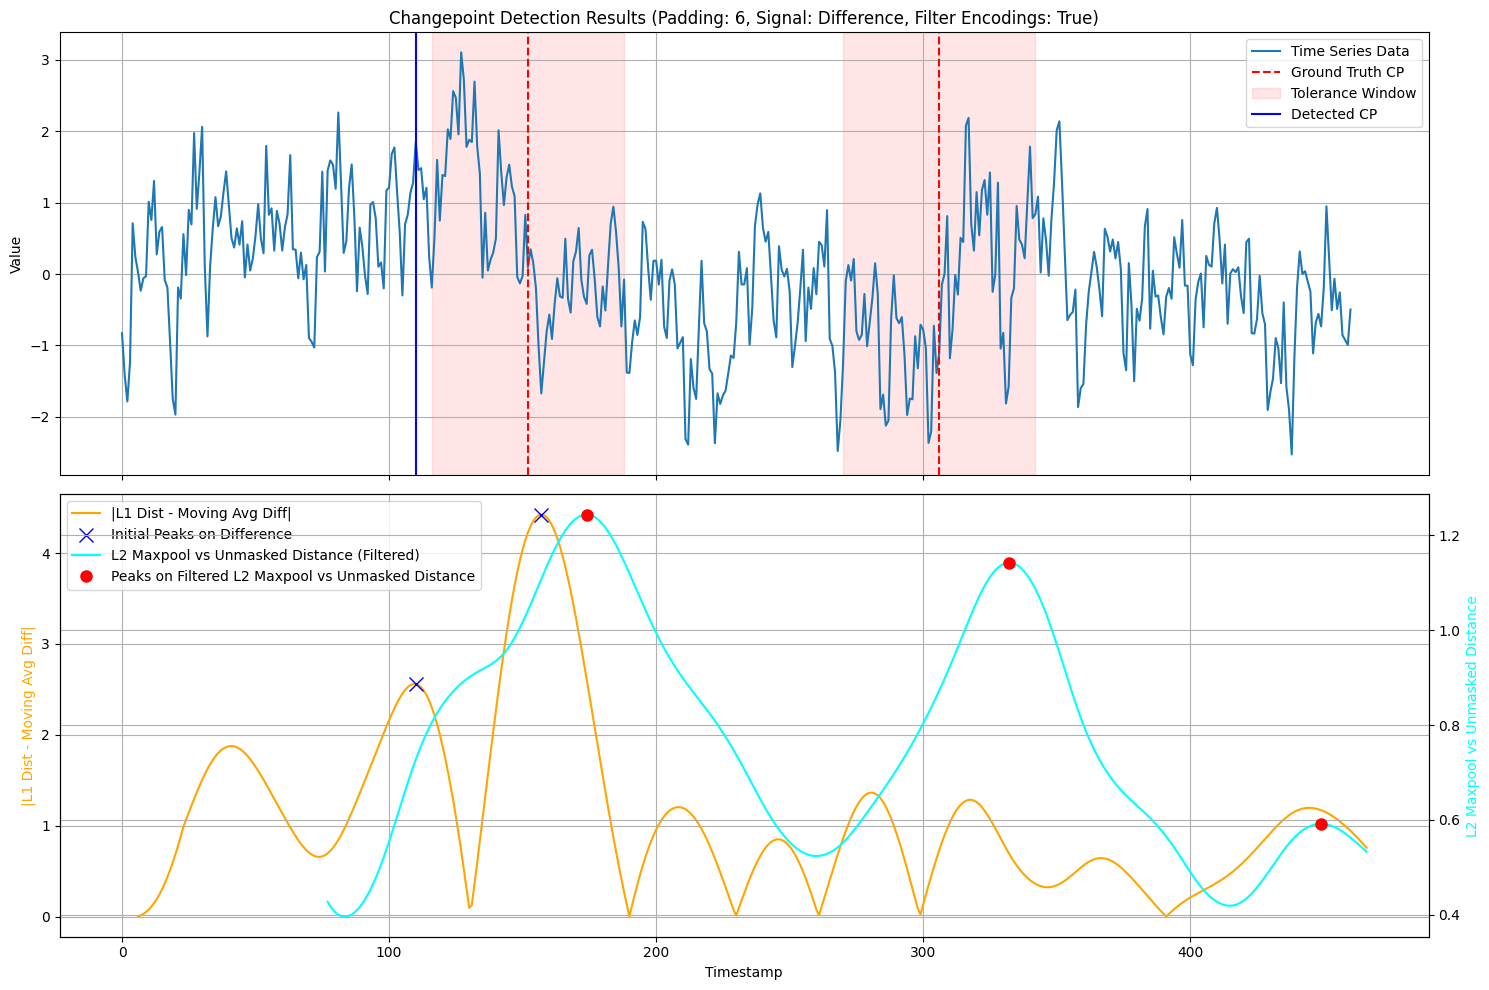

In [12]:
# @title Plot one with best ts2vec params
# Use the best hyperparameters found in original_best_params
best_params = original_best_params
# Print the best parameters for confirmation
print("Using Best Hyperparameters:")
print(best_params)

# Instantiate the TS2VecChangepointDetector with the best parameters
best_detector = TS2VecChangepointDetector(
    model=trained_model,
    sliding_length=1, # Keep fixed
    sliding_padding=6, # Keep fixed
    local_window_size=best_params['local_window_size'],
    prominence_threshold=best_params['prominence_threshold'],
    # prominence_threshold=1,
    moving_average_window=best_params['moving_average_window'],
    detection_signal=best_params['detection_signal'],
    apply_filter_to_encodings=True
)

# Generate one new data point for analysis
print("\nGenerating one new data point for analysis...")
# Generate a single instance (n_instances=1) and get the test split (train_split=0.0)
_, evaluation_data_single, _, evaluation_ground_truth_cps_single = generate_simulated_data(n_instances=1, train_split=0.0, M=2)
print("Data generation complete.")

# Extract the single instance data and its ground truth changepoints
# The shape of evaluation_data_single is (1, max_len, n_features)
instance_data = evaluation_data_single[0]
instance_ground_truth_cps = evaluation_ground_truth_cps_single[0]


print("\nPerforming changepoint detection on the single instance...")
# Detect changepoints for the single instance using the best detector
detected_changepoints = best_detector.detect_changepoints(instance_data, debug_peaks=True)
print(f"Detected {len(detected_changepoints)} changepoints.")


print("\nPlotting results for the single instance:")
# Plot results for the single instance
best_detector.plot_results(instance_data, ground_truth_cps=instance_ground_truth_cps)

# Optional: Evaluate performance for this single instance (for verification)
# tolerance = int(best_params['local_window_size'] * 0.8)
# tp, fp, fn, precision, recall, f1 = best_detector.evaluate_performance(
#     instance_ground_truth_cps,
#     detected_changepoints,
#     tolerance=tolerance
# )
# print("\nEvaluation for the single instance:")
# print(f"  TP: {tp}, FP: {fp}, FN: {fn}")
# print(f"  Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

In [16]:
# @title Evaluate best params over 1000 simulations
import pandas as pd
import numpy as np
from IPython.display import display
import ruptures as rpt # Import ruptures library

# --- Evaluate Best Hyperparameters on 1000 New Data Points ---

# Assuming 'original_best_params' variable for TS2Vec and 'original_best_pelt_params' for PELT
# are already defined from previous cross-validation steps.
if 'original_best_params' not in locals():
    print("Error: 'original_best_params' variable (for TS2Vec) not found. Please run the TS2Vec cross-validation step first.")
elif 'original_best_pelt_params' not in locals():
     print("Error: 'original_best_pelt_params' variable (for PELT) not found. Please run the PELT cross-validation step first.")
else:
    print("--- Evaluating Best Hyperparameters on 1000 New Data Points ---")

    # Print the best hyperparameters being used for TS2Vec
    print("\nTS2Vec Detector - Best Hyperparameters Used:")
    display(original_best_params)

    # Print the best hyperparameters being used for PELT
    print("\nPELT Detector - Best Hyperparameters Used:")
    display(original_best_pelt_params)


    # Instantiate the TS2VecChangepointDetector with the best parameters
    best_detector = TS2VecChangepointDetector(
        model=trained_model, # Assuming 'trained_model' is also defined
        sliding_length=1,
        sliding_padding=6,
        local_window_size=original_best_params['local_window_size'], # Use original_best_params
        prominence_threshold=original_best_params['prominence_threshold'], # Use original_best_params
        moving_average_window=original_best_params['moving_average_window'], # Use original_best_params
        detection_signal=original_best_params['detection_signal'], # Use original_best_params
        apply_filter_to_encodings=True
    )

    # Generate 1000 new data points for evaluation
    print("Generating 1000 new data points for evaluation...")
    # We only need the test data and its ground truth changepoints for evaluation
    _, evaluation_data, _, evaluation_ground_truth_cps = generate_simulated_data(n_instances=1000, train_split=0.0, M=2)
    print("Data generation complete.")

    # Lists to store evaluation results for each instance
    ts2vec_evaluation_results = []
    pelt_evaluation_results = []

    print("\nEvaluating performance on 1000 new data points...")
    for i in range(evaluation_data.shape[0]):
        instance_data = evaluation_data[i]
        instance_ground_truth_cps = evaluation_ground_truth_cps[i]

        # --- TS2Vec Changepoint Detection ---
        detected_changepoints_ts2vec = best_detector.detect_changepoints(instance_data)

        # Evaluate performance for TS2Vec
        tolerance = int(original_best_params['local_window_size'] * 0.8) # Use original_best_params for tolerance calculation
        tp_ts2vec, fp_ts2vec, fn_ts2vec, precision_ts2vec, recall_ts2vec, f1_ts2vec = best_detector.evaluate_performance(
            instance_ground_truth_cps,
            detected_changepoints_ts2vec,
            tolerance=tolerance
        )

        ts2vec_evaluation_results.append({
            'instance': i,
            'tp': tp_ts2vec,
            'fp': fp_ts2vec,
            'fn': fn_ts2vec,
            'precision': precision_ts2vec,
            'recall': recall_ts2vec,
            'f1': f1_ts2vec
        })

        # --- PELT Changepoint Detection using Ruptures ---
        # Ensure data is 1D for ruptures or reshape if needed
        # For univariate data, reshape to (n_timestamps,)
        # For multivariate data, ruptures expects (n_timestamps, n_features)
        if instance_data.shape[-1] == 1:
             pelt_data = instance_data.flatten()
        else:
             pelt_data = instance_data # ruptures handles (n_timestamps, n_features)

        # Define the PELT model with the best hyperparameters from cross-validation
        try:
            pelt_model = rpt.Pelt(model=original_best_pelt_params['model']).fit(pelt_data)

            # Predict changepoints using the best penalty from cross-validation
            pelt_detected_indices = pelt_model.predict(pen=original_best_pelt_params['penalty'])

            # Convert ruptures indices to timestamps. Remove the last element if it's the end of the series.
            # Ruptures predict() includes the length of the time series as the last element, which is not a changepoint.
            if pelt_detected_indices and pelt_detected_indices[-1] == len(pelt_data):
                pelt_detected_indices = pelt_detected_indices[:-1]

            # Convert 0-based indices (end of segment before CP) to 0-based timestamps (start of segment after CP)
            # Ruptures documentation indicates indices are *after* the changepoint location.
            # So, if ruptures returns [100, 250], changepoints are at timestamps 100 and 250 (0-indexed).
            # Let's assume ruptures returns the 0-indexed timestamp of the changepoint directly.
            detected_changepoints_pelt = pelt_detected_indices # Ruptures returns the start index of the segment after the changepoint

            # Evaluate performance for PELT
            # Use the same tolerance as for TS2Vec for a fair comparison
            tp_pelt, fp_pelt, fn_pelt, precision_pelt, recall_pelt, f1_pelt = evaluate_changepoint_detection( # Use the general evaluation function
                instance_ground_truth_cps,
                detected_changepoints_pelt,
                tolerance=tolerance
            )

            pelt_evaluation_results.append({
                'instance': i,
                'tp': tp_pelt,
                'fp': fp_pelt,
                'fn': fn_pelt,
                'precision': precision_pelt,
                'recall': recall_pelt,
                'f1': f1_pelt
            })
        except Exception as e:
             print(f"Warning: PELT detection failed for instance {i} with params {original_best_pelt_params} due to error: {e}")
             # Append results with zeros/NaNs for this failed instance to maintain list length
             pelt_evaluation_results.append({
                'instance': i,
                'tp': 0, 'fp': 0, 'fn': len(instance_ground_truth_cps), # Assume all ground truth are missed
                'precision': 0.0, 'recall': 0.0, 'f1': 0.0
            })


    print("Evaluation complete.")

    # Convert the evaluation results to pandas DataFrames
    ts2vec_evaluation_results_df = pd.DataFrame(ts2vec_evaluation_results)
    pelt_evaluation_results_df = pd.DataFrame(pelt_evaluation_results)

    # Calculate the aggregate performance metrics across all evaluation instances for TS2Vec
    total_tp_ts2vec = ts2vec_evaluation_results_df['tp'].sum()
    total_fp_ts2vec = ts2vec_evaluation_results_df['fp'].sum()
    total_fn_ts2vec = ts2vec_evaluation_results_df['fn'].sum()

    aggregate_precision_ts2vec = total_tp_ts2vec / (total_tp_ts2vec + total_fp_ts2vec) if (total_tp_ts2vec + total_fp_ts2vec) > 0 else 0.0
    aggregate_recall_ts2vec = total_tp_ts2vec / (total_tp_ts2vec + total_fn_ts2vec) if (total_tp_ts2vec + total_fn_ts2vec) > 0 else 0.0
    aggregate_f1_ts2vec = 2 * (aggregate_precision_ts2vec * aggregate_recall_ts2vec) / (aggregate_precision_ts2vec + aggregate_recall_ts2vec) if (aggregate_precision_ts2vec + aggregate_recall_ts2vec) > 0 else 0.0

    average_instance_f1_ts2vec = ts2vec_evaluation_results_df['f1'].mean()


    # Calculate the aggregate performance metrics across all evaluation instances for PELT
    total_tp_pelt = pelt_evaluation_results_df['tp'].sum()
    total_fp_pelt = pelt_evaluation_results_df['fp'].sum()
    total_fn_pelt = pelt_evaluation_results_df['fn'].sum()

    aggregate_precision_pelt = total_tp_pelt / (total_tp_pelt + total_fp_pelt) if (total_tp_pelt + total_fp_pelt) > 0 else 0.0
    aggregate_recall_pelt = total_tp_pelt / (total_tp_pelt + total_fn_pelt) if (total_tp_pelt + total_fn_pelt) > 0 else 0.0
    aggregate_f1_pelt = 2 * (aggregate_precision_pelt * aggregate_recall_pelt) / (aggregate_precision_pelt + aggregate_recall_pelt) if (aggregate_precision_pelt + aggregate_recall_pelt) > 0 else 0.0

    average_instance_f1_pelt = pelt_evaluation_results_df['f1'].mean()


    # --- Report Results ---

    print("\n--- Performance Comparison (Aggregate Metrics on 1000 New Data Points) ---")

    print("\nTS2Vec Changepoint Detector (using Best Hyperparameters):")
    print(f"  Total True Positives (TP): {total_tp_ts2vec}")
    print(f"  Total False Positives (FP): {total_fp_ts2vec}")
    print(f"  Total False Negatives (FN): {total_fn_ts2vec}")
    print(f"  Aggregate Precision: {aggregate_precision_ts2vec:.4f}")
    print(f"  Aggregate Recall: {aggregate_recall_ts2vec:.4f}")
    print(f"  Aggregate F1-score: {aggregate_f1_ts2vec:.4f}")
    print(f"  Average Instance F1-score: {average_instance_f1_ts2vec:.4f}")

    print("\nPELT Changepoint Detector (Ruptures, using Best Hyperparameters from CV):")
    print(f"  Best PELT Hyperparameters: {original_best_pelt_params}")
    print(f"  Total True Positives (TP): {total_tp_pelt}")
    print(f"  Total False Positives (FP): {total_fp_pelt}")
    print(f"  Total False Negatives (FN): {total_fn_pelt}")
    print(f"  Aggregate Precision: {aggregate_precision_pelt:.4f}")
    print(f"  Aggregate Recall: {aggregate_recall_pelt:.4f}")
    print(f"  Aggregate F1-score: {aggregate_f1_pelt:.4f}")
    print(f"  Average Instance F1-score: {average_instance_f1_pelt:.4f}")

--- Evaluating Best Hyperparameters on 1000 New Data Points ---

TS2Vec Detector - Best Hyperparameters Used:


{'local_window_size': 36,
 'prominence_threshold': 1.5,
 'moving_average_window': 18,
 'detection_signal': 'difference'}


PELT Detector - Best Hyperparameters Used:


{'penalty': np.float64(23.02585092994046), 'model': 'l2'}

Generating 1000 new data points for evaluation...
Data generation complete.

Evaluating performance on 1000 new data points...
Evaluation complete.

--- Performance Comparison (Aggregate Metrics on 1000 New Data Points) ---

TS2Vec Changepoint Detector (using Best Hyperparameters):
  Total True Positives (TP): 1005
  Total False Positives (FP): 530
  Total False Negatives (FN): 995
  Aggregate Precision: 0.6547
  Aggregate Recall: 0.5025
  Aggregate F1-score: 0.5686
  Average Instance F1-score: 0.5002

PELT Changepoint Detector (Ruptures, using Best Hyperparameters from CV):
  Best PELT Hyperparameters: {'penalty': np.float64(23.02585092994046), 'model': 'l2'}
  Total True Positives (TP): 1534
  Total False Positives (FP): 460
  Total False Negatives (FN): 466
  Aggregate Precision: 0.7693
  Aggregate Recall: 0.7670
  Aggregate F1-score: 0.7682
  Average Instance F1-score: 0.7499


**AR change in means, 100k training instances, 0.9 have changepoints**

TS2Vec Changepoint Detector (using Best Hyperparameters):
  Total True Positives (TP): 1147
  Total False Positives (FP): 749
  Total False Negatives (FN): 853
  Aggregate Precision: 0.6050
  Aggregate Recall: 0.5735
  Aggregate F1-score: 0.5888
  Average Instance F1-score: 0.5518

PELT Changepoint Detector (Ruptures, using Best Hyperparameters from CV):
  Best PELT Hyperparameters: {'penalty': np.float64(23.02585092994046), 'model': 'l2'}
  Total True Positives (TP): 1551
  Total False Positives (FP): 445
  Total False Negatives (FN): 449
  Aggregate Precision: 0.7771
  Aggregate Recall: 0.7755
  Aggregate F1-score: 0.7763
  Average Instance F1-score: 0.7591

In [18]:
import pandas as pd
import os
from datetime import datetime

# Define the directory and filename for aggregate results
save_directory = '/content/drive/MyDrive/_mlds_research_project/'
aggregate_save_filename = 'aggregate_results.csv'
aggregate_save_filepath = os.path.join(save_directory, aggregate_save_filename)

# Define the scenario and get the current timestamp
scenario = "AR change in means, 100k training instances, 0.9 have changepoints" # Ensure this matches the scenario used for the evaluation
results_saved_timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

# Extract the aggregate metrics for TS2Vec and PELT from the evaluation results
# These variables were calculated and printed in the previous cell (Jroq2YIq3rfp)
# Ensure these variables are available in the current environment or re-calculate if necessary
# Assuming total_tp_ts2vec, total_fp_ts2vec, total_fn_ts2vec, aggregate_precision_ts2vec,
# aggregate_recall_ts2vec, aggregate_f1_ts2vec, average_instance_f1_ts2vec,
# total_tp_pelt, total_fp_pelt, total_fn_pelt, aggregate_precision_pelt,
# aggregate_recall_pelt, aggregate_f1_pelt, average_instance_f1_pelt,
# and original_best_pelt_params are available from previous execution.

# Create DataFrames for the aggregate results
ts2vec_aggregate_df = pd.DataFrame([{
    'detector': 'TS2Vec',
    'scenario': scenario,
    'results_saved_timestamp': results_saved_timestamp,
    'total_tp': total_tp_ts2vec,
    'total_fp': total_fp_ts2vec,
    'total_fn': total_fn_ts2vec,
    'aggregate_precision': aggregate_precision_ts2vec,
    'aggregate_recall': aggregate_recall_ts2vec,
    'aggregate_f1': aggregate_f1_ts2vec,
    'average_instance_f1': average_instance_f1_ts2vec,
    'best_params': original_best_params # Include the best TS2Vec params
}])

pelt_aggregate_df = pd.DataFrame([{
    'detector': 'PELT',
    'scenario': scenario,
    'results_saved_timestamp': results_saved_timestamp,
    'total_tp': total_tp_pelt,
    'total_fp': total_fp_pelt,
    'total_fn': total_fn_pelt,
    'aggregate_precision': aggregate_precision_pelt,
    'aggregate_recall': aggregate_recall_pelt,
    'aggregate_f1': aggregate_f1_pelt,
    'average_instance_f1': average_instance_f1_pelt,
    'best_params': original_best_pelt_params # Include the best PELT params
}])

# Concatenate the aggregate results
new_aggregate_results_df = pd.concat([ts2vec_aggregate_df, pelt_aggregate_df], ignore_index=True)

# Convert 'best_params' dictionary column to a string representation for saving to CSV
new_aggregate_results_df['best_params'] = new_aggregate_results_df['best_params'].apply(lambda x: str(x))


# Check if the aggregate results file already exists
if os.path.exists(aggregate_save_filepath):
    print(f"Appending aggregate results to existing file: {aggregate_save_filepath}")
    # Read the existing CSV file
    existing_aggregate_results_df = pd.read_csv(aggregate_save_filepath)

    # Append the new aggregate results to the existing DataFrame
    combined_aggregate_results_df = pd.concat([existing_aggregate_results_df, new_aggregate_results_df], ignore_index=True)
else:
    print(f"Creating new aggregate results file: {aggregate_save_filepath}")
    # If the file does not exist, the new aggregate results are the combined results
    combined_aggregate_results_df = new_aggregate_results_df

# Save the combined aggregate DataFrame back to the CSV file, overwriting the old one
combined_aggregate_results_df.to_csv(aggregate_save_filepath, index=False)

print("Aggregate results saved successfully.")

Creating new aggregate results file: /content/drive/MyDrive/_mlds_research_project/aggregate_results.csv
Aggregate results saved successfully.
